In [252]:
#Import libraries

import os
import wget
import numpy as np
import pandas as pd
from math import floor
from pydap.client import open_url
from tqdm import tqdm
import sys
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import cv2
import matplotlib
from matplotlib.colors import ListedColormap
from pathlib import Path
import datetime


plt.rcParams["figure.figsize"] = 12, 8

In [253]:
current_path = os.getcwd()
current_path

'/home/luisfigueiredo/JUNO/notebooks'

In [254]:
data_folder = '/home/luisfigueiredo/JUNO/data'
data_folder

'/home/luisfigueiredo/JUNO/data'

In [255]:
nc_path = os.path.join(data_folder, 'CCA_MUR_fronts.nc')
ds = nc.Dataset(nc_path)
data = xr.load_dataset(nc_path, decode_times=False)

In [256]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: CCA MUR Fronts Arrays
    dimensions(sizes): time(10), lat(1001), lon(1401)
    variables(dimensions): float32 time(time), float32 lat(lat), float32 lon(lon), uint8 value(time, lat, lon)
    groups: 


In [257]:
ds.variables['time'][:]

masked_array(data=[737211., 737212., 737213., 737214., 737215., 737216.,
                   737217., 737218., 737219., 737220.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [258]:
datetime.datetime.fromordinal(ds['time'][0].data.astype(int))

datetime.datetime(2019, 6, 1, 0, 0)

In [259]:
data

<xarray.Dataset>
Dimensions:  (lat: 1001, lon: 1401, time: 10)
Coordinates:
  * time     (time) float32 7.372e+05 7.372e+05 ... 7.372e+05 7.372e+05
  * lat      (lat) float32 35.0 35.01 35.02 35.03 ... 44.97 44.98 44.99 45.0
  * lon      (lon) float32 -19.0 -18.99 -18.98 -18.97 ... -5.03 -5.02 -5.01 -5.0
Data variables:
    value    (time, lat, lon) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    title:    CCA MUR Fronts Arrays

In [141]:
x = datetime.datetime.fromordinal(int(data['time'][0]))
x

datetime.datetime(2019, 6, 1, 0, 0)

In [142]:
data['time']

<xarray.DataArray 'time' (time: 10)>
array([737211., 737212., 737213., 737214., 737215., 737216., 737217., 737218.,
       737219., 737220.], dtype=float32)
Coordinates:
  * time     (time) float32 7.372e+05 7.372e+05 ... 7.372e+05 7.372e+05
Attributes:
    units:    days since 1-1-1

In [144]:
len(data.time)

10

In [132]:
x = data.value[0]
x

<xarray.DataArray 'value' (lat: 1001, lon: 1401)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
    time     float32 7.372e+05
  * lat      (lat) float32 35.0 35.01 35.02 35.03 ... 44.97 44.98 44.99 45.0
  * lon      (lon) float32 -19.0 -18.99 -18.98 -18.97 ... -5.03 -5.02 -5.01 -5.0
Attributes:
    units:    Unknown

In [67]:
np.unique(x)

array([0, 1], dtype=uint8)

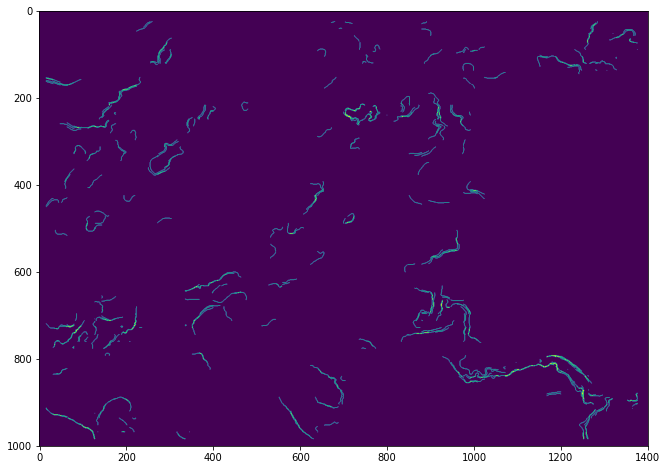

In [66]:
plt.imshow(x)

In [145]:
count = 0
fronts = np.zeros((1001, 1401))
for i in range(len(data.time)):
    
    fronts = fronts + data.value[i]
    count += 1
    
frontal_prob = fronts/count

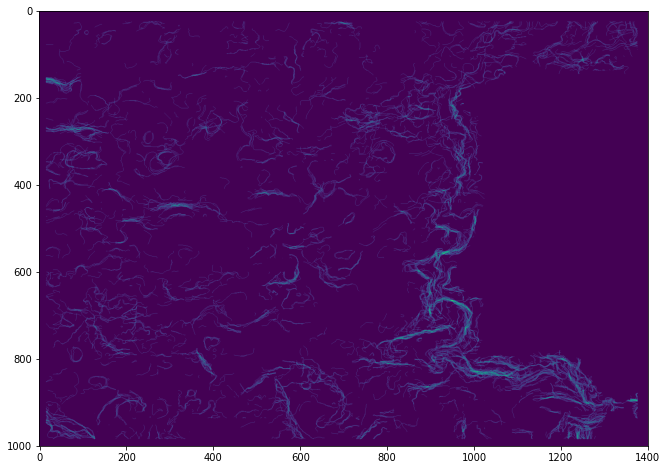

In [146]:
plt.imshow(frontal_prob)

In [72]:
np.unique(frontal_prob)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

# ------------------------------------------------------------------------------------------------------
### Get MUR data for 1 day to map the continental zone

In [153]:
data_folder

'/home/luisfigueiredo/JUNO/data'

In [154]:
nc_map_path = os.path.join(data_folder, "sst_20220615.nc")
ds = nc.Dataset(nc_map_path)
data_map = xr.load_dataset(nc_map_path)

In [155]:
#Convert the netCDF file to a dataframe
datadf = data_map.to_dataframe()
datadf = datadf.reset_index()

In [156]:
datadf['analysed_sst'] =  datadf['analysed_sst']-273.15    #convert to celsius
datadf

,lat,lon,time,analysed_sst
0,35.0,-19.000000,2022-06-15 09:00:00,19.606995
1,35.0,-18.990000,2022-06-15 09:00:00,19.595001
2,35.0,-18.980000,2022-06-15 09:00:00,19.583008
3,35.0,-18.969999,2022-06-15 09:00:00,19.571991
4,35.0,-18.959999,2022-06-15 09:00:00,19.559998
...,...,...,...,...
1402396,45.0,-5.040000,2022-06-15 09:00:00,18.338013
1402397,45.0,-5.030000,2022-06-15 09:00:00,18.338989
1402398,45.0,-5.020000,2022-06-15 09:00:00,18.339996
1402399,45.0,-5.010000,2022-06-15 09:00:00,18.339996


In [157]:
sst = datadf.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values

mask = np.isnan(np.flipud(sst))    #Boolean array: True where array Temp had Null Values (correspond to the continental zone)
mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which values= 255 when mask=True
#Dilation to ensure that the pixels that belong to the "shore/continental zone" are not considered fronts 
kernel = np.ones((3,3), np.uint8)
mask_dilated = cv2.dilate(mask255, kernel)

frontal_prob =np.ma.masked_where(mask_dilated==255, frontal_prob)   #Mask an array where a condition is met.

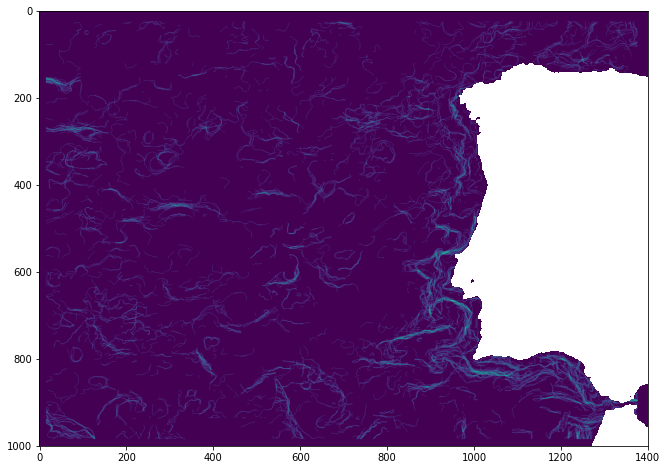

In [158]:
plt.imshow(frontal_prob)

# -----------------------------------------------------------------------------------------------

### Frontal Probabilities Map with Continental Zone Mapped

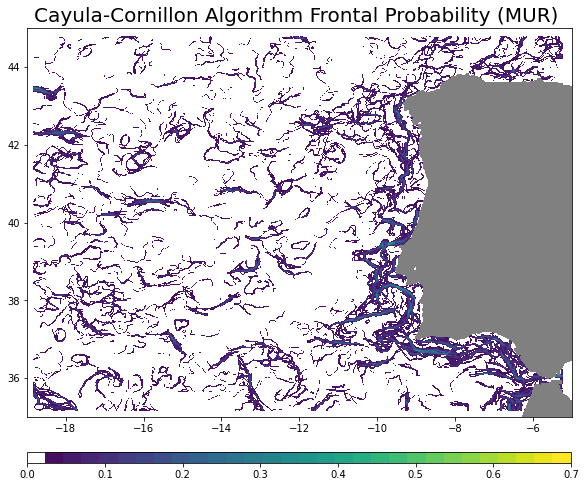

In [164]:
lat = data['lat'].values
lon = data['lon'].values

#Visualization purposes: continenal area in gray, and pixels with value=0 in white   
viridis = matplotlib.cm.get_cmap('viridis', 30)
newcolor = viridis(np.linspace(0,1,30))
white = np.array([1, 1, 1, 1])
newcolor[0, :] = white
newcmp = ListedColormap(newcolor)
newcmp.set_bad(color='gray')

plt.figure()
plt.imshow(frontal_prob, cmap=newcmp, extent = [lon[0], lon[-1], lat[0], lat[-1]], interpolation='bilinear')    
#extent is to define the extention of the x and y axis
plt.title("Cayula-Cornillon Algorithm Frontal Probability (MUR) ", fontsize=20)
plt.colorbar(orientation='horizontal', fraction=0.025, pad=0.08, aspect=50)

# -----------------------------------------------------------------------------------------------------

In [182]:
data

<xarray.Dataset>
Dimensions:  (lat: 1001, lon: 1401, time: 10)
Coordinates:
  * time     (time) float32 7.372e+05 7.372e+05 ... 7.372e+05 7.372e+05
  * lat      (lat) float32 35.0 35.01 35.02 35.03 ... 44.97 44.98 44.99 45.0
  * lon      (lon) float32 -19.0 -18.99 -18.98 -18.97 ... -5.03 -5.02 -5.01 -5.0
Data variables:
    value    (time, lat, lon) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    title:    CCA MUR Fronts Arrays

In [183]:
len(data['time'])

10

In [186]:
li = []
for i in range(len(data['time'])):
    li.append(datetime.datetime.fromordinal(int(data['time'][i])))


In [187]:
li

[datetime.datetime(2019, 6, 1, 0, 0),
 datetime.datetime(2019, 6, 2, 0, 0),
 datetime.datetime(2019, 6, 3, 0, 0),
 datetime.datetime(2019, 6, 4, 0, 0),
 datetime.datetime(2019, 6, 5, 0, 0),
 datetime.datetime(2019, 6, 6, 0, 0),
 datetime.datetime(2019, 6, 7, 0, 0),
 datetime.datetime(2019, 6, 8, 0, 0),
 datetime.datetime(2019, 6, 9, 0, 0),
 datetime.datetime(2019, 6, 10, 0, 0)]

In [238]:
datas = pd.date_range(start='2019-06-03', end ='2019-06-05').to_pydatetime().tolist()

In [239]:
datas

[datetime.datetime(2019, 6, 3, 0, 0),
 datetime.datetime(2019, 6, 4, 0, 0),
 datetime.datetime(2019, 6, 5, 0, 0)]

In [250]:
count = 0
fronts = np.zeros((1001, 1401))
for i in range(len(data.time)):
    
    if li[i] in datas:
    
        fronts = fronts + data.value[i]
        count += 1
    
frontal_prob = fronts/count

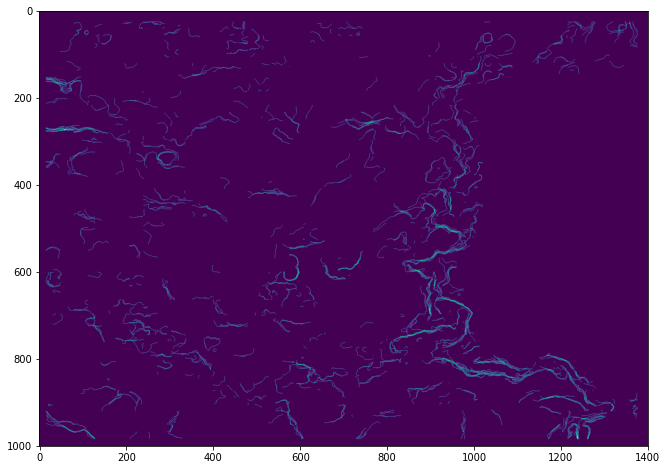

In [251]:
plt.imshow(frontal_prob)

## Create a list with datetime.datetime dos Verões (J, A e S) de 2012 a 2021

In [235]:
import itertools
summer_10years = []
start_year = 2012
i = 0
#for i in range(10):
while start_year < 2022:
    summer_10years.append(pd.date_range(start=str(start_year)+'-06-01', end = str(start_year)+'-08-31').to_pydatetime().tolist())
    start_year += 1
    
summer_10years = list(itertools.chain.from_iterable(summer_10years))   #convert list of list to only 1 list

In [236]:
summer_10years

[datetime.datetime(2012, 6, 1, 0, 0),
 datetime.datetime(2012, 6, 2, 0, 0),
 datetime.datetime(2012, 6, 3, 0, 0),
 datetime.datetime(2012, 6, 4, 0, 0),
 datetime.datetime(2012, 6, 5, 0, 0),
 datetime.datetime(2012, 6, 6, 0, 0),
 datetime.datetime(2012, 6, 7, 0, 0),
 datetime.datetime(2012, 6, 8, 0, 0),
 datetime.datetime(2012, 6, 9, 0, 0),
 datetime.datetime(2012, 6, 10, 0, 0),
 datetime.datetime(2012, 6, 11, 0, 0),
 datetime.datetime(2012, 6, 12, 0, 0),
 datetime.datetime(2012, 6, 13, 0, 0),
 datetime.datetime(2012, 6, 14, 0, 0),
 datetime.datetime(2012, 6, 15, 0, 0),
 datetime.datetime(2012, 6, 16, 0, 0),
 datetime.datetime(2012, 6, 17, 0, 0),
 datetime.datetime(2012, 6, 18, 0, 0),
 datetime.datetime(2012, 6, 19, 0, 0),
 datetime.datetime(2012, 6, 20, 0, 0),
 datetime.datetime(2012, 6, 21, 0, 0),
 datetime.datetime(2012, 6, 22, 0, 0),
 datetime.datetime(2012, 6, 23, 0, 0),
 datetime.datetime(2012, 6, 24, 0, 0),
 datetime.datetime(2012, 6, 25, 0, 0),
 datetime.datetime(2012, 6, 26, 0,